In [2]:
# 3D grating simulation
import math
import os
from pathlib import Path

import meep.adjoint as mpa
import numpy as np
from autograd import grad
from autograd import numpy as npa
from autograd import tensor_jacobian_product
from matplotlib import pyplot as plt
from matplotlib.patches import Circle
from scipy import signal, special

import meep as mp
import nlopt  # need install nlopt
plt.style.use("seaborn")

%matplotlib inline
%config InlineBackend.figure_format = 'svg'
np.random.seed(0)

mp.verbosity(0)

os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"
cur_path = Path().resolve()
opt_path = cur_path.parent / "global_opt/positive_angle/opt_1/"

/home/suda/miniconda3/envs/mp/lib/python3.11/site-packages/numpy/core/getlimits.py:518: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/home/suda/miniconda3/envs/mp/lib/python3.11/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)
/home/suda/miniconda3/envs/mp/lib/python3.11/site-packages/numpy/core/getlimits.py:518: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/home/suda/miniconda3/envs/mp/lib/python3.11/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  return self._float_to_str(self.smallest_subnormal)
/tmp/ipykernel_13211/870407769.py:17: MatplotlibDeprecationWarning: The se

8.373640724839385e-06


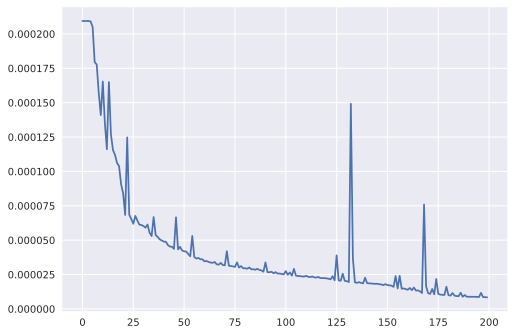

In [3]:
evaluation_history = np.load(opt_path / "eval_history.npy")
plt.plot(evaluation_history)
print(evaluation_history[-1])

In [4]:
# init_file
evaluation_histary_files = []
epses = []
eps_files = []
eps_file = opt_path / "final_eps.npy"
eps = np.load(eps_file)
epses.append(eps)
# wg_gap数量与eps数量相同
wg_gap = []
wg_gap.append(0)
wg_gap.append(0)
# total_eps = np.concatenate(epses, axis=0)

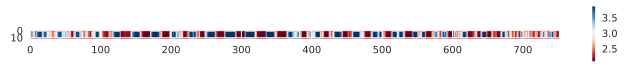

In [5]:
# plot the eps to verify
plt.figure(figsize=(12, 1))
plt.imshow(np.rot90(np.abs(epses[0])), cmap='RdBu')
plt.colorbar()

**Basic Setup**

In [15]:
# size of input and output waveguide
w = 0.5
h = 0.2

# resolution size
grid = 0.02
resolution = 1 / grid
design_res = resolution

# thickness of PML
dpml = 1

##################### length parameter ################
input_wvg_length = 5
output_wvg_length = 5
# design_region
design_region_x = np.zeros(len(epses))
for ii in range(0, len(epses)):
    design_region_x[ii] = len(epses[ii]) * (1 / design_res) / 5
design_region_y = 0.2
sx = (
    input_wvg_length
    + np.sum(design_region_x)
    + np.sum(wg_gap)
    + output_wvg_length
    + 2 * dpml
)

##################### height parameter ################
Substrate_thickness = 0.5
BOX_thickness = 2
TOX_thickness = 0.7
near_field_height = 1
sy = BOX_thickness + TOX_thickness + Substrate_thickness + near_field_height + 2 * dpml

wg_z = 5
sz = wg_z + 2 + 2 * dpml
cell = mp.Vector3(sx, sy, sz)

# Material setting
Si = mp.Medium(index=3.45)
SiO2 = mp.Medium(index=1.44)
SiN = mp.Medium(index=1.96)

####################### geometry ##########################
Substrate_geo = mp.Block(
    material=Si,
    center=mp.Vector3(y=-0.5 * sy + 0.5 * Substrate_thickness + dpml),
    size=mp.Vector3(sx, Substrate_thickness, sz),
)
BOX_geo = mp.Block(
    material=SiO2,
    center=mp.Vector3(y=-0.5 * sy + Substrate_thickness + 0.5 * BOX_thickness + dpml),
    size=mp.Vector3(sx, BOX_thickness, sz),
)
TOX_geo = mp.Block(
    material=SiO2,
    center=mp.Vector3(
        y=-0.5 * sy + Substrate_thickness + BOX_thickness + 0.5 * TOX_thickness + dpml
    ),
    size=mp.Vector3(sx, TOX_thickness, sz),
)
input_waveguide_geo = mp.Block(
    material=SiN,
    center=mp.Vector3(
        -0.5 * sx + 0.5 * input_wvg_length,
        -0.5 * sy + Substrate_thickness + BOX_thickness + 0.5 * h + dpml,
    ),
    size=mp.Vector3(input_wvg_length + 2 * dpml, h, wg_z),
)
output_waveguide_geo = mp.Block(
    material=SiN,
    center=mp.Vector3(
        0.5 * sx - 0.5 * output_wvg_length,
        -0.5 * sy + Substrate_thickness + BOX_thickness + 0.5 * h + dpml,
    ),
    size=mp.Vector3(output_wvg_length + 2 * dpml, h, wg_z),
)


geometry = [
    Substrate_geo,
    BOX_geo,
    TOX_geo,
    input_waveguide_geo,
    output_waveguide_geo,
]

wvl = 0.785
fcen = 1 / wvl
fwidth = 0.2 * fcen
kpoint = mp.Vector3(1, 0, 0)

# waveguide source
sources = [
    mp.EigenModeSource(
        mp.GaussianSource(frequency=fcen, fwidth=fwidth),
        center=input_waveguide_geo.center,
        size=mp.Vector3(0, 3 * h, wg_z + 2),
        eig_band=1,
        eig_parity=mp.NO_PARITY,
        eig_match_freq=True,
        direction=mp.NO_DIRECTION,
        eig_kpoint=kpoint,
    )
]
# set nomrlized source: amplitude is 1 -> flux is 1
sources[0].amplitude = 1 / mp.GaussianSource(fcen, fwidth=fwidth).fourier_transform(
    fcen
)

sim = mp.Simulation(
    resolution=resolution,
    cell_size=cell,
    boundary_layers=[mp.PML(dpml)],
    sources=sources,
    geometry=geometry,
)

In [12]:
sz

9

In [13]:
input_waveguide_geo.center

Vector3<-11.02, 0.4999999999999999, 0.0>

<Axes: xlabel='X', ylabel='Y'>

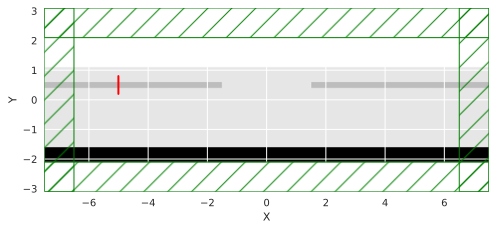

In [17]:
# xy plane
xy_plane = mp.Volume(center=mp.Vector3(0, 0, 0), size=mp.Vector3(sx, sy, 0))
sim.plot2D(output_plane=xy_plane)

<Axes: xlabel='X', ylabel='Z'>

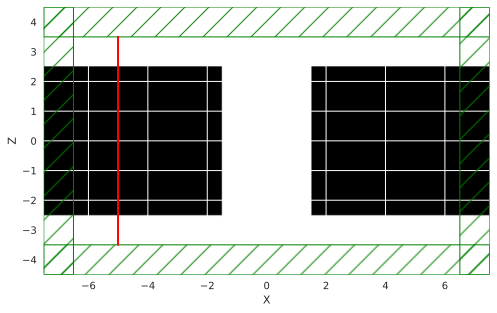

In [16]:
# xz plane
xz_plane = mp.Volume(
    center=mp.Vector3(0, input_waveguide_geo.center.y, 0), size=mp.Vector3(sx, 0, sz)
)
sim.plot2D(output_plane=xz_plane)

In [19]:
mpt = mp.Vector3(output_waveguide_geo.center.x - 3, input_waveguide_geo.center.y, 0)

# f = plt.figure(dpi=100)
# Animate = mp.Animate2D(fields=mp.Ez, f=f, realtime=False, normalize=True)

sim.run(
    # mp.at_every(1, Animate),
    until_after_sources=mp.stop_when_fields_decayed(50, mp.Ez, mpt, 1e-5),
)

KeyboardInterrupt: 